# Sentiment Analysis using Glove and Logistic Regression

Citations:
- https://medium.com/@jonathan_hui/nlp-word-embedding-glove-5e7f523999f6
- https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010

In [24]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding="utf8") as f:
    line = f.readline()
    while line:
        values = line.split()
        word = values[0]
        try:
           coefs = np.asarray(values[1:], dtype='float32')
           embeddings_index[word] = coefs
        except ValueError:
           pass
        line = f.readline()


In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df = pd.read_csv('../data/Reviews.csv')
df['Text'] = df['Text'] + ' ' + df['Summary']

In [4]:
# Delete unused columns
del df['Id']
del df['ProfileName']
del df['Summary']
del df['HelpfulnessNumerator']
del df['HelpfulnessDenominator']
del df['Time']
del df['ProductId']

In [5]:
df.head()

,UserId,Score,Text
0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


In [6]:
df.loc[df['Score'] <= 3, 'ReviewSentiment'] = 0
df.loc[df['Score'] > 3, 'ReviewSentiment'] = 1

df['ReviewSentiment'] = df['ReviewSentiment'].astype(int)

In [7]:
df.isna().sum()

UserId              0
Score               0
Text               27
ReviewSentiment     0
dtype: int64

In [8]:
#convert na to ""
df['Text'].fillna("", inplace=True)

In [9]:
def preprocess(s):
    # Remove html tags
    s = re.sub('<\S+>', '', s)
    # Replace urls with token
    s = re.sub(r'http:\S+', 'url', s)
    s = re.sub(r'https:\S+', 'url', s)
    
    s = s.lower()
    # Remove any other special characters
    s = re.sub(r'[^a-z ]', ' ', s)
    
    words = s.split()
    result = []
    
    # Remove stop words and lemmatize the words
    for word in words:
        if word in stop_words:
            continue
        word = lemmatizer.lemmatize(word)
        result.append(word)
    return ' '.join(result)

df['Text'] = df['Text'].apply(preprocess)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df['Text'], df['ReviewSentiment'], test_size=0.2, random_state=1, stratify=df['ReviewSentiment'])
print('Number of train samples:', len(x_train))
print('Number of test samples:', len(x_test))

Number of train samples: 454763
Number of test samples: 113691


In [11]:
# Delete unused objects
del stop_words
del lemmatizer
del df

In [12]:
def doc2vec(s):
    words = word_tokenize(s)
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [13]:
print(x_train[0])
print(y_train[0])

bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better good quality dog food
1


In [14]:
xtrain_glove = [doc2vec(x) for x in tqdm(x_train)]

100%|██████████| 454763/454763 [02:48<00:00, 2693.87it/s]


In [15]:
xtest_glove = [doc2vec(x) for x in tqdm(x_test)]

100%|██████████| 113691/113691 [00:42<00:00, 2649.83it/s]


In [ ]:
print('Starting GridSearchCV Training...')
lr = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, class_weight='balanced', verbose=1)
parameters = {'C':[2,5,8,10]}
#lr.fit(xtrain_glove, y_train.tolist())
grid_cv = GridSearchCV(lr, parameters)
grid_cv.fit(xtrain_glove, y_train.tolist())
print('GridSearchCV Training Complete.')

In [ ]:
print('Accuracy on Test data:', grid_cv.score(xtest_glove, y_test))

In [23]:
#pickle.dump(grid_cv, open('model/lr_glove_grid_model', 'wb'))
loaded_grid_cv = pickle.load(open('model/lr_glove_grid_model', 'rb'))
print('Loaded GridCV Model on test data:', loaded_grid_cv.score(xtest_glove, y_test.tolist()))

Loaded GridCV Model on test data: 0.8092285229261771


Text(0.5, 1.0, 'C vs Mean Test Score')

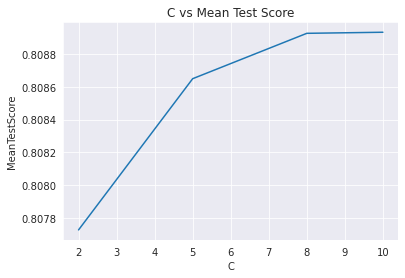

In [25]:
sns.set_style("darkgrid")

C = []
mean_acc = []
for i, param in enumerate(loaded_grid_cv.cv_results_['params']):
    C.append(param['C'])
    mean_acc.append(loaded_grid_cv.cv_results_['mean_test_score'][i])
data = pd.DataFrame({'C':C, 'MeanTestScore':mean_acc})

sns.lineplot(x='C',y='MeanTestScore', data=data, ci= None).set_title('C vs Mean Test Score')